<a href="https://colab.research.google.com/github/Kryptera-K/SMCI-Multi-Layer-Momentum-Compression-Strategy/blob/main/SMCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "SMCI"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("SMCI_clean.csv", index=False)
df

/tmp/ipython-input-3086563415.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2007-03-29,0.876000,0.931000,0.866000,0.885000,60798000
2007-03-30,0.899000,0.900000,0.855000,0.883000,4195000
2007-04-02,1.038000,1.059000,0.899000,0.900000,7491000
2007-04-03,1.058000,1.166000,1.040000,1.070000,8357000
2007-04-04,1.016000,1.099000,1.003000,1.040000,3095000
...,...,...,...,...,...
2025-10-21,54.820000,55.349998,53.910000,55.160000,29016500
2025-10-22,52.500000,54.529999,50.029999,54.490002,34326200
2025-10-23,47.919998,51.840000,47.380001,51.730000,57175700


In [ ]:
BB_PERIOD = 20
BB_SHIFT = 5
BB_STD = 2
ICHIMOKU_DISPLACEMENT = 26
ICHIMOKU_KIJUN_PERIOD = 26
ICHIMOKU_SENKOU_B_PERIOD = 52
ICHIMOKU_TENKAN_PERIOD = 9
KVO_LEVEL = 0
KVO_LONG = 55
KVO_SHORT = 34
KVO_SIGNAL = 13
QQE_FACTOR = 4.236
QQE_LEVEL = 50
QQE_PERIOD = 14
QQE_SHIFT = 5
QQE_SMOOTH = 5

# -------------------------
# Indicator Functions
# -------------------------

def kvo_signal_is_rising(df):
    df = klinger_volume_oscillator(df)
    return df['KVO_Signal'].diff() > 0


def klinger_volume_oscillator(df, short=KVO_SHORT, long=KVO_LONG, signal=KVO_SIGNAL):
    dm = df['High'] - df['Low']
    cm = np.cumsum(np.where(df['Close'] > df['Close'].shift(1), dm, -dm))
    vf = df['Volume'] * abs(2 * (df['Close'] - df['Low']) / (df['High'] - df['Low']) - 1)
    kvo = vf.ewm(span=short).mean() - vf.ewm(span=long).mean()
    df['KVO'] = kvo
    df['KVO_Signal'] = kvo.ewm(span=signal).mean()
    return df


def qqe_value1_lower_than_level(df, level=QQE_LEVEL):
    df = calculate_qqe(df)
    return df['QQE_Value1'] < level


def calculate_qqe(df, rsi_period=QQE_PERIOD, smooth=QQE_SMOOTH, factor=QQE_FACTOR):
    """
    Calculate QQE lines (Value1 & Value2) based on RSI smoothing and ATR-like smoothing.
    """
    df = df.copy()

    # --- RSI ---
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/rsi_period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/rsi_period, adjust=False).mean()
    rsi = 100 - (100 / (1 + roll_up / roll_down))

    # --- Smoothed RSI ---
    rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')

    # --- RSI Delta & ATR-like smoothing ---
    rsi_delta = rsi_ma.diff().abs().fillna(0)
    atr_rsi = rsi_delta.ewm(alpha=1/smooth, adjust=False).mean()

    # --- QQE Calculation ---
    value1 = rsi_ma.copy()
    value2 = pd.Series(index=df.index, dtype=float)
    value2.iloc[0] = value1.iloc[0]

    for i in range(1, len(df)):
        prev_trail = value2.iloc[i-1]
        prev_value1 = value1.iloc[i-1]
        atr = atr_rsi.iloc[i]
        direction = 1 if prev_value1 > prev_trail else -1
        value2.iloc[i] = prev_trail + direction * factor * atr

    df['QQE_Value1'] = value1
    df['QQE_Value2'] = value2

    return df


def kumo_breakout_bearish(df):
    df = calculate_ichimoku(df)
    return df['Close'] < df[['senkou_span_a', 'senkou_span_b']].min(axis=1)


def calculate_ichimoku(df, tenkan_period=ICHIMOKU_TENKAN_PERIOD, kijun_period=ICHIMOKU_KIJUN_PERIOD, senkou_b_period=ICHIMOKU_SENKOU_B_PERIOD, displacement=ICHIMOKU_DISPLACEMENT):
    df = df.copy()

    # Lines
    df['tenkan_sen'] = (df['High'].rolling(tenkan_period).max() + df['Low'].rolling(tenkan_period).min()) / 2
    df['kijun_sen'] = (df['High'].rolling(kijun_period).max() + df['Low'].rolling(kijun_period).min()) / 2
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(displacement)
    df['senkou_span_b'] = ((df['High'].rolling(senkou_b_period).max() + df['Low'].rolling(senkou_b_period).min()) / 2).shift(displacement)
    df['chikou_span'] = df['Close'].shift(-displacement)

    return df


def bb_squeeze(df, period=BB_PERIOD, std_multiplier=BB_STD, shift=BB_SHIFT):
    """
    Detect Bollinger Band Squeeze (bands narrowing)
    """
    df = calculate_bollinger_bands(df, period, std_multiplier)
    bandwidth = df['BB_Upper'] - df['BB_Lower']
    return bandwidth < bandwidth.shift(shift)


def calculate_bollinger_bands(df, period=BB_PERIOD, std_multiplier=BB_STD):
    """
    Calculate Bollinger Bands: Middle, Upper, and Lower.
    """
    df = df.copy()
    df['BB_MA'] = df['Close'].rolling(window=period).mean()
    df['BB_Upper'] = df['BB_MA'] + std_multiplier * df['Close'].rolling(window=period).std()
    df['BB_Lower'] = df['BB_MA'] - std_multiplier * df['Close'].rolling(window=period).std()
    return df



# -------------------------
# Entry conditions
# -------------------------

df["KVO_Signal_is_Rising"] = kvo_signal_is_rising(df)
df["QQE_Value1_LowerThan_Level"] = qqe_value1_lower_than_level(df)

# -------------------------
# Exit conditions
# -------------------------

df["Ichimoku_Kumo_Breakout_Bearish"] = kumo_breakout_bearish(df)
df["BB_Squeeze"] = bb_squeeze(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'KVO_Signal_is_Rising',
    'QQE_Value1_LowerThan_Level',
]
exit_conditions = [
    'Ichimoku_Kumo_Breakout_Bearish',
    'BB_Squeeze',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

/tmp/ipython-input-1954276556.py:57: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')


Start                                2007-03-29 00:00:00
End                                  2025-10-27 00:00:00
Period                                4676 days 00:00:00
Start Value                                     100000.0
End Value                                10190699.704781
Total Return [%]                            10090.699705
Benchmark Return [%]                         5522.598741
Max Gross Exposure [%]                             100.0
Total Fees Paid                            225719.451357
Max Drawdown [%]                               66.303409
Max Drawdown Duration                 1226 days 00:00:00
Total Trades                                          66
Total Closed Trades                                   66
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   53.030303
Best Trade [%]                                295.345061
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2007-03-29 00:00:00
End                           2025-10-27 00:00:00
Period                         4676 days 00:00:00
Start Value                              100000.0
End Value                          5622598.740988
Total Return [%]                      5522.598741
Benchmark Return [%]                  5522.598741
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        85.313532
Max Drawdown Duration          1684 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                     5522598.740988
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-1622420870.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1622420870.py:73: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



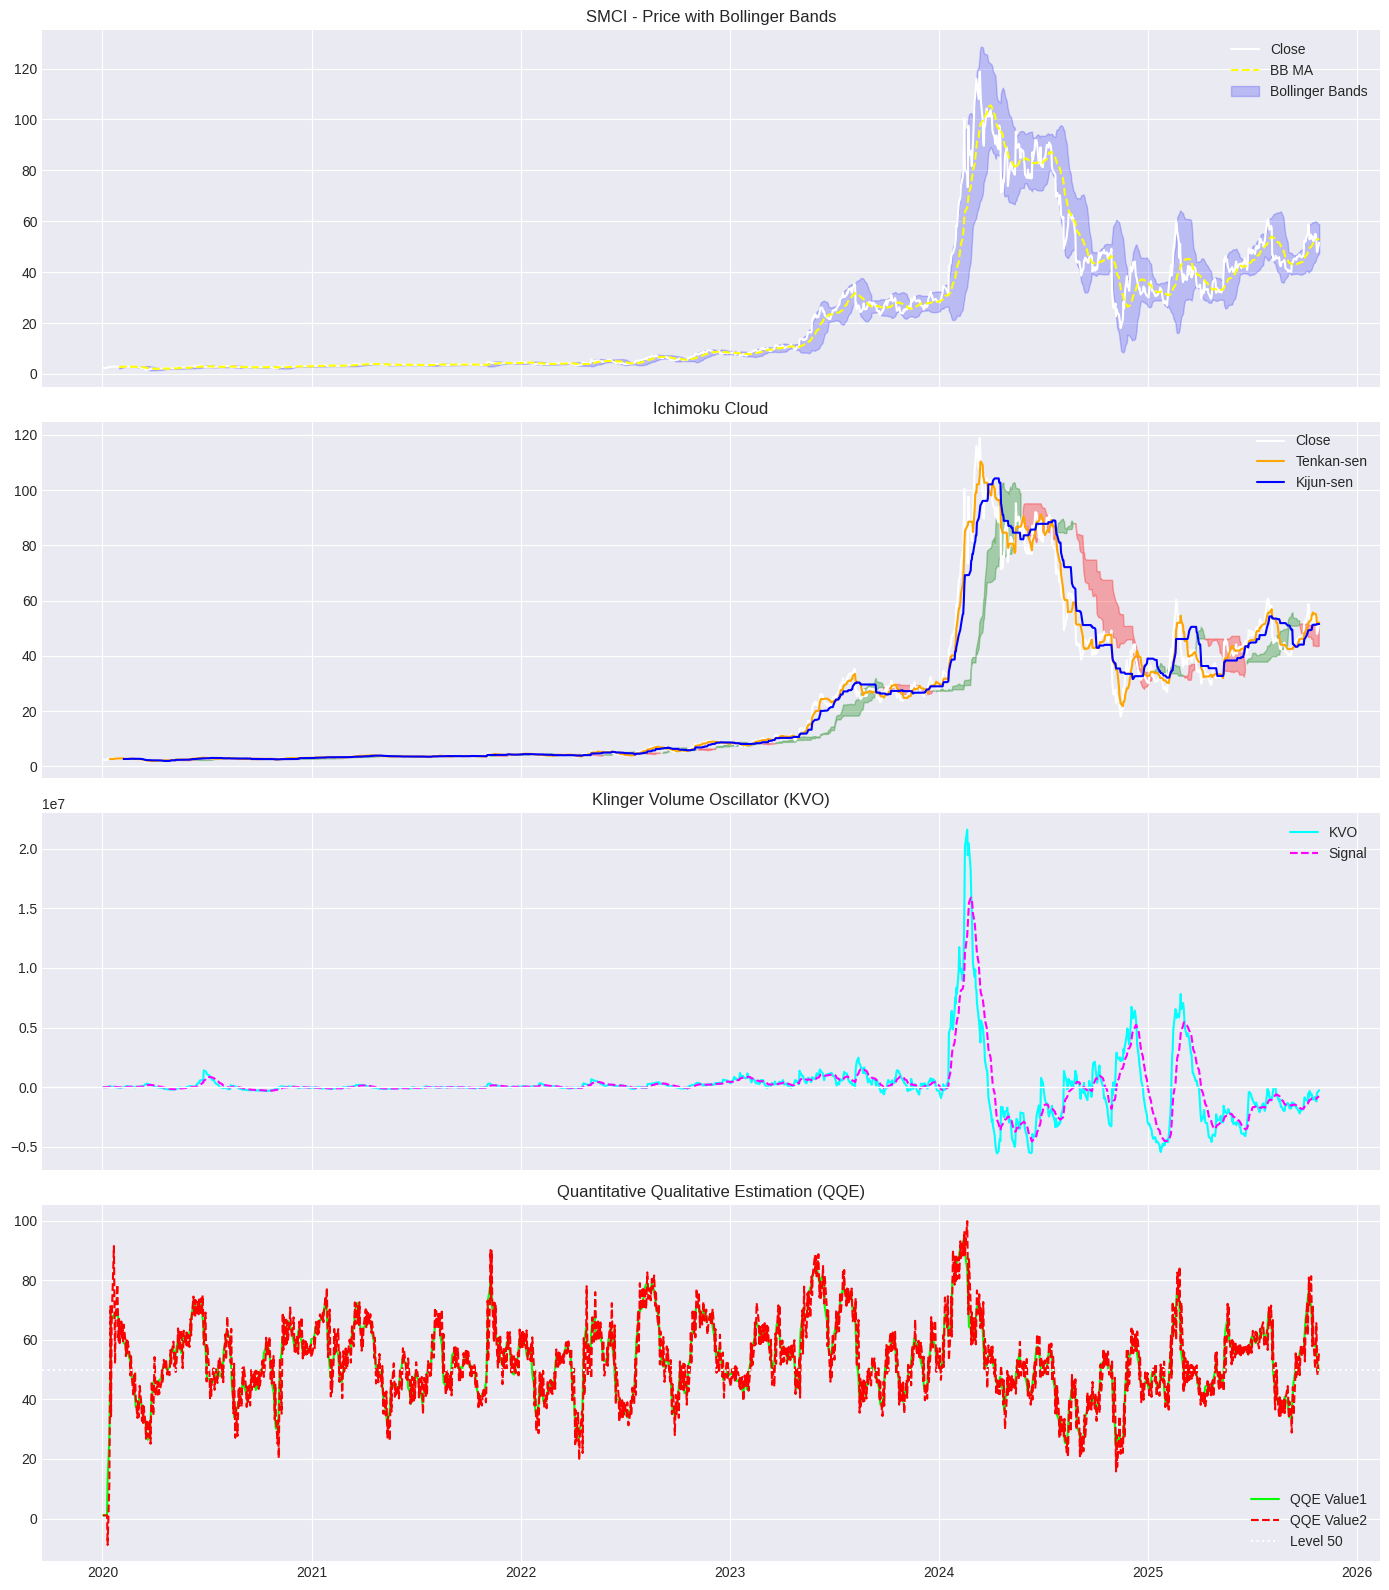

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------
symbol = "SMCI"
start_date = "2020-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.dropna(inplace=True)

# -------------------------
# Parameters
# -------------------------
BB_PERIOD = 20
BB_SHIFT = 5
BB_STD = 2
ICHIMOKU_DISPLACEMENT = 26
ICHIMOKU_KIJUN_PERIOD = 26
ICHIMOKU_SENKOU_B_PERIOD = 52
ICHIMOKU_TENKAN_PERIOD = 9
KVO_LONG = 55
KVO_SHORT = 34
KVO_SIGNAL = 13
QQE_FACTOR = 4.236
QQE_LEVEL = 50
QQE_PERIOD = 14
QQE_SMOOTH = 5

# -------------------------
# Indicator Functions
# -------------------------
def calculate_bollinger_bands(df, period=BB_PERIOD, std_multiplier=BB_STD):
    df = df.copy()
    df['BB_MA'] = df['Close'].rolling(window=period).mean()
    df['BB_Upper'] = df['BB_MA'] + std_multiplier * df['Close'].rolling(window=period).std()
    df['BB_Lower'] = df['BB_MA'] - std_multiplier * df['Close'].rolling(window=period).std()
    return df

def calculate_ichimoku(df, tenkan_period=ICHIMOKU_TENKAN_PERIOD, kijun_period=ICHIMOKU_KIJUN_PERIOD,
                       senkou_b_period=ICHIMOKU_SENKOU_B_PERIOD, displacement=ICHIMOKU_DISPLACEMENT):
    df = df.copy()
    df['tenkan_sen'] = (df['High'].rolling(tenkan_period).max() + df['Low'].rolling(tenkan_period).min()) / 2
    df['kijun_sen'] = (df['High'].rolling(kijun_period).max() + df['Low'].rolling(kijun_period).min()) / 2
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(displacement)
    df['senkou_span_b'] = ((df['High'].rolling(senkou_b_period).max() + df['Low'].rolling(senkou_b_period).min()) / 2).shift(displacement)
    df['chikou_span'] = df['Close'].shift(-displacement)
    return df

def klinger_volume_oscillator(df, short=KVO_SHORT, long=KVO_LONG, signal=KVO_SIGNAL):
    df = df.copy()
    dm = df['High'] - df['Low']
    cm = np.cumsum(np.where(df['Close'] > df['Close'].shift(1), dm, -dm))
    vf = df['Volume'] * abs(2 * (df['Close'] - df['Low']) / (df['High'] - df['Low']) - 1)
    kvo = vf.ewm(span=short).mean() - vf.ewm(span=long).mean()
    df['KVO'] = kvo
    df['KVO_Signal'] = kvo.ewm(span=signal).mean()
    return df

def calculate_qqe(df, rsi_period=QQE_PERIOD, smooth=QQE_SMOOTH, factor=QQE_FACTOR):
    df = df.copy()
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/rsi_period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/rsi_period, adjust=False).mean()
    rsi = 100 - (100 / (1 + roll_up / roll_down))
    rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')
    rsi_delta = rsi_ma.diff().abs().fillna(0)
    atr_rsi = rsi_delta.ewm(alpha=1/smooth, adjust=False).mean()

    value1 = rsi_ma.copy()
    value2 = pd.Series(index=df.index, dtype=float)
    value2.iloc[0] = value1.iloc[0]
    for i in range(1, len(df)):
        prev_trail = value2.iloc[i-1]
        prev_value1 = value1.iloc[i-1]
        atr = atr_rsi.iloc[i]
        direction = 1 if prev_value1 > prev_trail else -1
        value2.iloc[i] = prev_trail + direction * factor * atr

    df['QQE_Value1'] = value1
    df['QQE_Value2'] = value2
    return df

# -------------------------
# Calculate Indicators
# -------------------------
df = calculate_bollinger_bands(df)
df = calculate_ichimoku(df)
df = klinger_volume_oscillator(df)
df = calculate_qqe(df)

# -------------------------
# Plot Section
# -------------------------
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

# --- 1. Price with Bollinger Bands ---
axes[0].plot(df.index, df['Close'], label='Close', color='white')
axes[0].plot(df.index, df['BB_MA'], label='BB MA', color='yellow', linestyle='--')
axes[0].fill_between(df.index, df['BB_Upper'], df['BB_Lower'], color='blue', alpha=0.2, label='Bollinger Bands')
axes[0].set_title(f"{symbol} - Price with Bollinger Bands")
axes[0].legend()

# --- 2. Ichimoku Cloud ---
axes[1].plot(df.index, df['Close'], label='Close', color='white')
axes[1].plot(df.index, df['tenkan_sen'], label='Tenkan-sen', color='orange')
axes[1].plot(df.index, df['kijun_sen'], label='Kijun-sen', color='blue')
axes[1].fill_between(df.index, df['senkou_span_a'], df['senkou_span_b'],
                     where=df['senkou_span_a'] >= df['senkou_span_b'],
                     color='green', alpha=0.3)
axes[1].fill_between(df.index, df['senkou_span_a'], df['senkou_span_b'],
                     where=df['senkou_span_a'] < df['senkou_span_b'],
                     color='red', alpha=0.3)
axes[1].set_title("Ichimoku Cloud")
axes[1].legend()

# --- 3. Klinger Volume Oscillator ---
axes[2].plot(df.index, df['KVO'], label='KVO', color='cyan')
axes[2].plot(df.index, df['KVO_Signal'], label='Signal', color='magenta', linestyle='--')
axes[2].axhline(0, color='white', linewidth=1)
axes[2].set_title("Klinger Volume Oscillator (KVO)")
axes[2].legend()

# --- 4. QQE ---
axes[3].plot(df.index, df['QQE_Value1'], label='QQE Value1', color='lime')
axes[3].plot(df.index, df['QQE_Value2'], label='QQE Value2', color='red', linestyle='--')
axes[3].axhline(QQE_LEVEL, color='white', linestyle=':', label=f'Level {QQE_LEVEL}')
axes[3].set_title("Quantitative Qualitative Estimation (QQE)")
axes[3].legend()

plt.tight_layout()
plt.show()
